In [2]:
%cd ..
%reload_ext autoreload
%autoreload 2

D:\ownCloud\Uni\Semester Ma 5\3D Scanning & Motion Capture (IN2354)\Project\3D-FaceReconstruction


In [208]:
import numpy as np
import trimesh
import dlib
import cv2
import pyrender
import matplotlib.pyplot as plt

from scipy import optimize

from face_reconstruction.landmarks import load_bfm_landmarks, detect_landmarks
from face_reconstruction.model import BaselFaceModel

from env import DATA_PATH, MODELS_PATH

# 1. Face Model

In [316]:
bfm = BaselFaceModel.from_h5("model2019_face12.h5")
bfm_landmarks = load_bfm_landmarks("model2019_face12_landmarks")

In [6]:
n_shape_coefficients = bfm.get_n_shape_coefficients()
n_expression_coefficients = bfm.get_n_expression_coefficients()
n_color_coefficients = bfm.get_n_color_coefficients()

In [7]:
shape_coefficients = [0 for _ in range(n_shape_coefficients)]
expression_coefficients = [0 for _ in range(n_expression_coefficients)]
color_coefficients = [0 for _ in range(n_color_coefficients)]

In [8]:
face_mesh = bfm.draw_sample(shape_coefficients, expression_coefficients, color_coefficients)
face_trimesh = bfm.convert_to_trimesh(face_mesh)

In [9]:
reconstructed = bfm.shape_model.get_mean() + bfm.expression_model.get_mean()
reconstructed = reconstructed.reshape((-1, 3))

# 2. Input image

In [55]:
img_path = f"{DATA_PATH}/Keypoint Detection/trump.jpg"
img = cv2.imread(img_path)

In [66]:
landmarks_img = detect_landmarks(img)

In [101]:
img_width = img.shape[1]
img_height = img.shape[0]

In [287]:
perspective_camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
projection_matrix = perspective_camera.get_projection_matrix(width=img_width, height=img_height)
projection_matrix

array([[ 2.19550972,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.73205081,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.        , -0.1       ],
       [ 0.        ,  0.        , -1.        ,  0.        ]])

In [303]:
initial_camera_position = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -300], [0, 0, 0, 1]]) # position camera just in front of face

In [311]:
def project_points(points):
    if not isinstance(points, np.ndarray):
        points = np.array(points)
    if points.shape[1] == 3:
        points = np.hstack((points, np.ones((points.shape[0], 1), dtype=points.dtype)))
    points_projected = projection_matrix @ initial_camera_position @ points.T
    points_screen = points_projected / points_projected[2,:]
    points_screen[1, :] = -points_screen[1, :]
    points_pixels = (points_screen + 1) / 2 * np.array([[img_width], [img_height], [0], [0]])
    points_pixels = points_pixels[:2,:].T
    points_pixels = np.rint(points_pixels).astype(int)
    return points_pixels

In [279]:
points = np.zeros((100, 4))
points[:25] = np.array([[i, 5, 0, 1] for i in range(25)])
points[25:50] = np.array([[0, 5 + i, 0, 1] for i in range(25)])
points[50:75] = np.array([[0 + i, 5 + 25, 0, 1] for i in range(25)])
points[75:] = np.array([[0 + 25, 5 + i, 0, 1] for i in range(25)])

In [328]:
landmark_points = np.array(face_mesh.vertices)[list(bfm_landmarks.values())]

In [329]:
points_pixels = project_points(landmark_points)

In [312]:
points_pixels = project_points(face_mesh.vertices)

In [293]:
points_pixels = project_points(points)

In [330]:
test_img = np.zeros((img_height, img_width))
for pixel in points_pixels:
    
    if pixel[0] >= 0 and pixel[0] < img_width and pixel[1] >= 0 and pixel[1] < img_height:
        test_img[pixel[1], pixel[0]] = 1

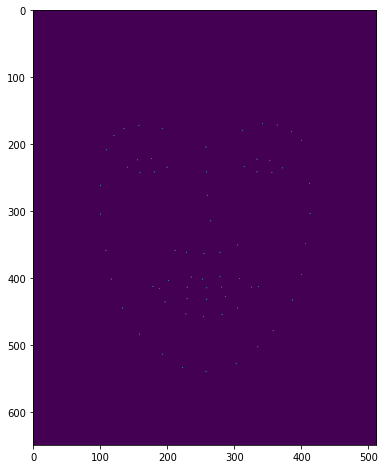

In [331]:
plt.figure(figsize=(12, 8))
plt.imshow(test_img)

In [48]:
class OptimizationParameters:
    
    def __init__(self, theta):
        self.shape_coefficients = theta[:n_shape_coefficients]
        self.expression_coefficients = theta[n_shape_coefficients:n_shape_coefficients + n_expression_coefficients]

In [46]:
def loss(theta, *args, **kwargs):
    shape_coefficients = theta[:n_shape_coefficients]
    expression_coefficients = theta[n_shape_coefficients ]

In [47]:
optimize.least_squares(loss, np.array([100]))

 active_mask: array([0.])
        cost: 0.0
         fun: array([0.])
        grad: array([0.])
         jac: array([[2.00000001]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 12
        njev: 12
  optimality: 0.0
      status: 1
     success: True
           x: array([1.])